In [1]:
! pip install transformers

     |████████████████████████████████| 3.1 MB 5.5 MB/s 
     |████████████████████████████████| 61 kB 516 kB/s 
     |████████████████████████████████| 596 kB 40.3 MB/s 
     |████████████████████████████████| 3.3 MB 41.7 MB/s 
     |████████████████████████████████| 895 kB 41.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
! pip install torch

In [3]:
! pip install pytorch-pretrained-bert

     |████████████████████████████████| 123 kB 5.4 MB/s 
     |████████████████████████████████| 131 kB 34.7 MB/s 
     |████████████████████████████████| 8.4 MB 34.0 MB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 138 kB 54.9 MB/s 
     |████████████████████████████████| 127 kB 52.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

# Specifing GPU
device = torch.device("cuda")
print(device)

cuda


In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np

import gensim
import re
import html
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, manifold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc

from transformers import BertTokenizer, TFBertForSequenceClassification, AdamW
from transformers import AutoModel, BertTokenizerFast

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout

In [26]:
#DATA

df_train = pd.read_csv("/content/data/train.csv")
df_test = pd.read_csv("/content/data/test.csv")
df_labels = pd.read_csv("/content/data/submit.csv")

df_test['label'] = df_labels['label']

df = pd.concat([df_train, df_test]).reset_index(drop=True)

df.drop(columns=['author'], inplace=True)

# Combining 'title' and 'text' colmuns together
df['original'] = df['title'] + ' ' + df['text']

# Shuffling data
df = df.sample(frac=1)
# Dropping duplicates & NaN rows
df.drop_duplicates(subset=['text'], inplace=True)
df.dropna(subset = ["text"], inplace=True)
df.dropna(subset = ["title"], inplace=True)

In [32]:
#DATA CLEANING

# Obtaining additional stopwords from nltk
stop_words = stopwords.words('english')

def cleaning(text):
    clean = re.sub('<.*?>', ' ', str(text))         
# Removing HTML tags
    clean = re.sub('\'.*?\s',' ', clean)               
# Removing all hanging letters afer apostrophes (s in it's)
    clean = re.sub(r'http\S+',' ', clean)              
# Removing URLs
    clean = re.sub('\W+',' ', clean)                   
# Replacing the non alphanumeric characters
    return html.unescape(clean)
df['cleaned'] = df['original'].apply(cleaning)


def stopwords(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Taking words that don't belong to stopwords and have more than 2 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result
df['nostopwords'] = df['cleaned'].apply(stopwords)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [33]:
# Lemmatizing
wnl = WordNetLemmatizer()
df['clean_lemm'] = df['nostopwords'].apply(lambda x: [wnl.lemmatize(word, pos="v") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="a") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="n") for word in x])

In [34]:
# All unique words present in dataset in one string
df['clean_joined'] = df['clean_lemm'].apply(lambda x: " ".join(x))
print(df['clean_joined'])


5797     vacancy black donald trump start accuse bias y...
21895    federation greek woman statement visit obama n...
15144    bloomberg consumer comfort index high decade b...
5565     turkey bomb support kurd syria kill early tues...
13056    trump offer father luck check inaugural event ...
                               ...                        
5265     buzz reporter mystery witness scene durst hear...
920      pennsylvania republican push private sale brei...
18311    debate possibility worry campaign york time hi...
4997     like onstage oscar best picture mistake york t...
25806    job market self sufficient brexit say green lo...
Name: clean_joined, Length: 24802, dtype: object


In [11]:
# Loading the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [35]:
# Splitting train dataset into train, validation and test sets and dropping NaN before that
df = df.dropna()
x_train, x_temp, y_train, y_temp = train_test_split(df['clean_joined'], df['label'], random_state=2018, test_size=0.25, stratify=df['label'])

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, random_state=2018, test_size=0.5, stratify=y_temp)

In [36]:
# Tokenizing and encoding sequences
tokens_train = tokenizer.batch_encode_plus( x_train.tolist(), max_length = 25, pad_to_max_length=True, truncation=True)
tokens_val = tokenizer.batch_encode_plus( x_val.tolist(), max_length = 25, pad_to_max_length=True, truncation=True)
tokens_test = tokenizer.batch_encode_plus( x_test.tolist(), max_length = 25, pad_to_max_length=True, truncation=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [37]:
# Converting lists to tensors

train_tokens_tensor = torch.tensor(tokens_train['input_ids'])
train_masks_tensor = torch.tensor(tokens_train['attention_mask'])
train_y_tensor = torch.tensor(y_train.tolist())

val_tokens_tensor = torch.tensor(tokens_val['input_ids'])
val_masks_tensor = torch.tensor(tokens_val['attention_mask'])
val_y_tensor = torch.tensor(y_val.tolist())

test_tokens_tensor = torch.tensor(tokens_test['input_ids'])
test_masks_tensor = torch.tensor(tokens_test['attention_mask'])
test_y_tensor = torch.tensor(y_test.tolist())

# Prepairing dataloaders
batch_size = 32

train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(val_tokens_tensor, val_masks_tensor, val_y_tensor)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)


In [15]:
#BUILDING AND TRAINING PRETRAINED MODEL

# Loading BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels - 2 for binary classification.
              
)

# Pushing the model to GPU
model = model.to(device)

100%|██████████| 407873900/407873900 [00:12<00:00, 33279264.79B/s]


In [38]:
# Computing the class weights
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)

# Converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# Pushing weights to GPU
weights = weights.to(device)

# Defining the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

In [17]:
# Defining the ADAM optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)          # lr - learning rate

In [18]:
# Training the model
def train():
  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  # Model predictions
  total_preds=[]

  for step,batch in enumerate(train_dataloader):
    
    # Progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # Pushing the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # Clearing previously calculated gradients 
    model.zero_grad()        

    # Getting model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # Adding on to the total loss
    total_loss = total_loss + loss.item()

    # Backward pass to calculate the gradients
    loss.backward()

    # Clipping the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Updating parameters
    optimizer.step()

    # Pushing model predictions to CPU
    preds=preds.detach().cpu().numpy()

    # Appending the model predictions
    total_preds.append(preds)

  # Computing the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # Reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [19]:
# Evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # Model predictions
  total_preds = []

  # Iterating over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches
    if step % 50 == 0 and not step == 0:
            
      # Reporting progress
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # Pushing the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # Deactivating autograd
    with torch.no_grad():
      
      # Model predictions
      preds = model(sent_id, mask)

      # Computing the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # Computing the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # Reshaping the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [39]:
# Number of training epochs
epochs = 2

# Setting initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Training model
    train_loss, _ = train()
    
    # Evaluating model
    valid_loss, _ = evaluate()
    
    # Saving the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # Appending training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    582.
  Batch   100  of    582.
  Batch   150  of    582.
  Batch   200  of    582.
  Batch   250  of    582.
  Batch   300  of    582.
  Batch   350  of    582.
  Batch   400  of    582.
  Batch   450  of    582.
  Batch   500  of    582.
  Batch   550  of    582.

Evaluating...
  Batch    50  of     97.

Training Loss: -19.707
Validation Loss: -21.882

 Epoch 2 / 2
  Batch    50  of    582.
  Batch   100  of    582.
  Batch   150  of    582.
  Batch   200  of    582.
  Batch   250  of    582.
  Batch   300  of    582.
  Batch   350  of    582.
  Batch   400  of    582.
  Batch   450  of    582.
  Batch   500  of    582.
  Batch   550  of    582.

Evaluating...
  Batch    50  of     97.

Training Loss: -23.849
Validation Loss: -25.931


In [40]:
# Loading weights of best model
path = 'saved_weights.pt'

# Getting predictions for test data
with torch.no_grad():
  preds = model(test_tokens_tensor.to(device), test_masks_tensor.to(device))
  preds = preds.detach().cpu().numpy()


preds = np.argmax(preds, axis = 1)

Model accuracy is :  0.9216381812318607
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1588
           1       0.92      0.92      0.92      1513

    accuracy                           0.92      3101
   macro avg       0.92      0.92      0.92      3101
weighted avg       0.92      0.92      0.92      3101



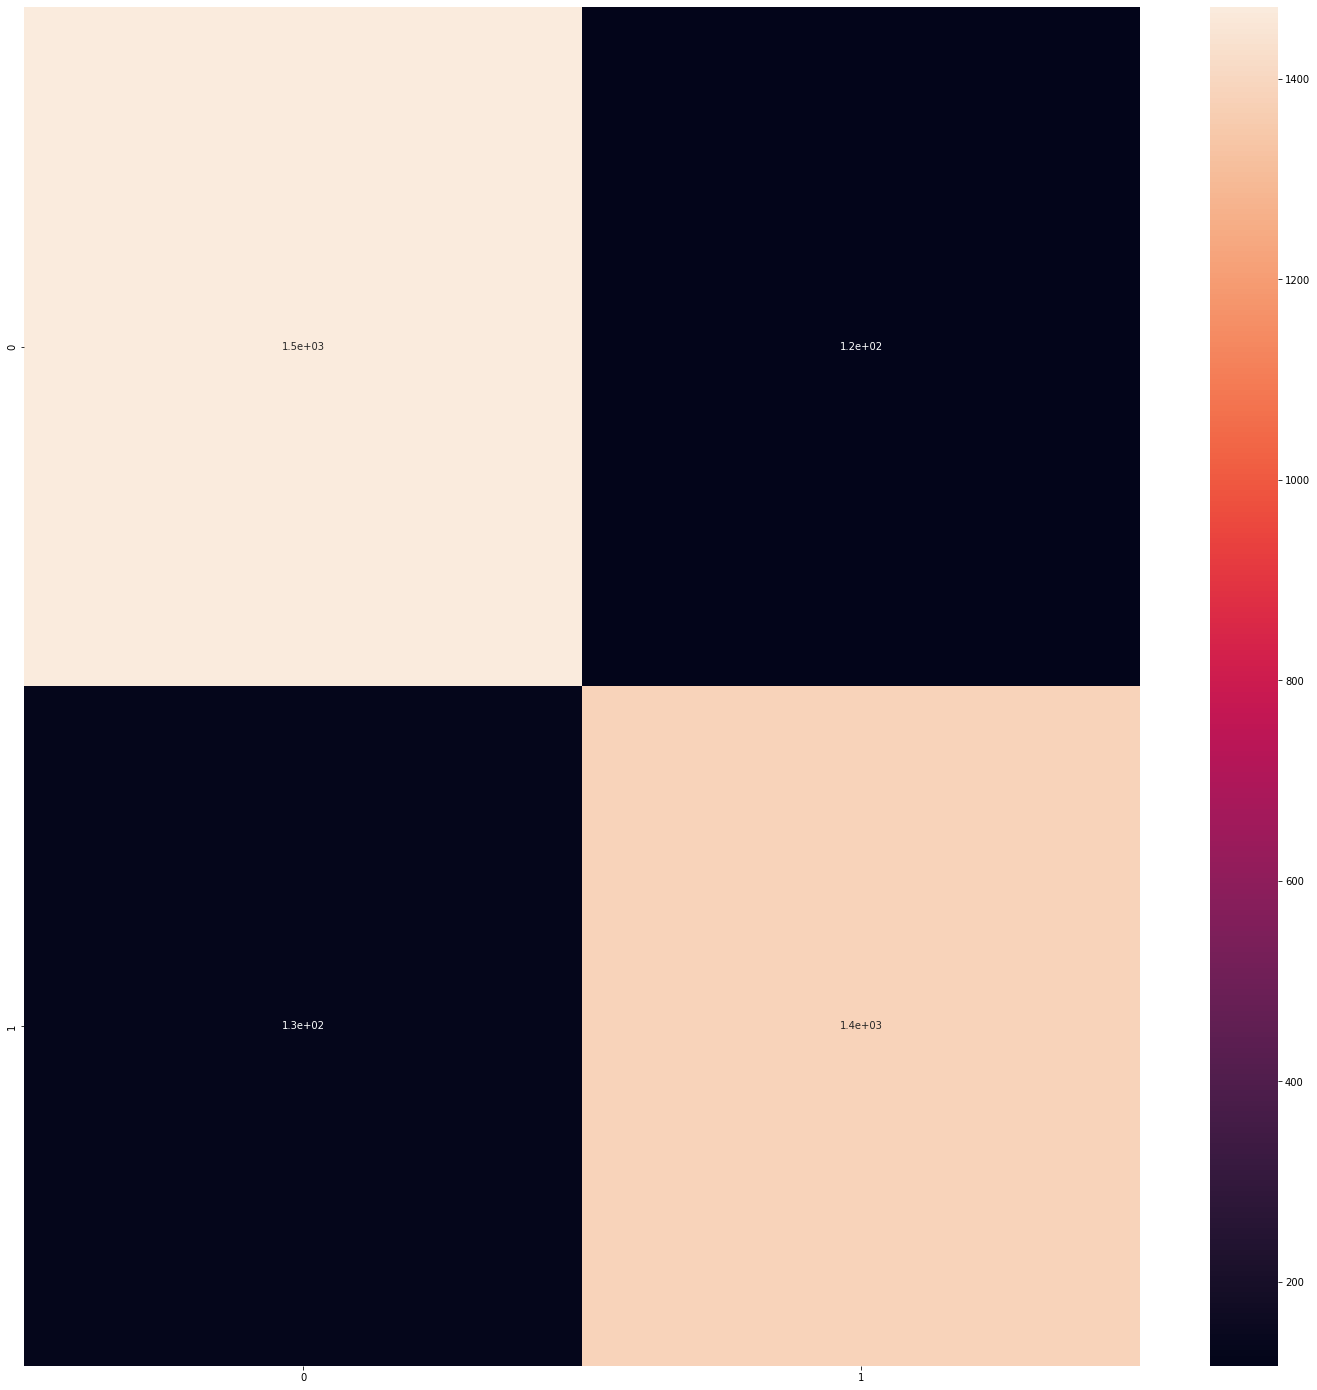

In [41]:
# EVALUATION OF THE BERT MODEL

prediction = []
# If hte prediction is > 0.5 then the news is real otherwise it is fake
for i in range(len(preds)):
    if preds[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model accuracy is : ", accuracy)
print(classification_report(y_test, prediction))

# Confusion matrix
c_matrix = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(25,25))
sns.heatmap(c_matrix, annot=True)
plt.show()

No Skill: ROC AUC=0.500
BERT: ROC AUC=0.922


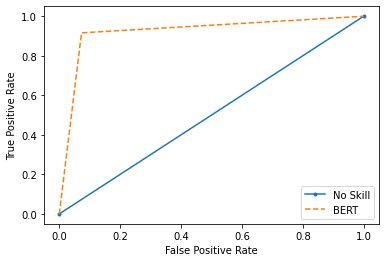

In [46]:
#ROC-CURVE

# Generetong a no skill prediction
ns_probs = [0 for _ in range(len(y_test))]

# Calculating scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, preds)

# Summarizing scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('BERT: ROC AUC=%.3f' % (lr_auc))

# Calculating ROC curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, preds)

# Plotting ROC curves
pyplot.plot(ns_fpr, ns_tpr, marker='.', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, linestyle='--', label='BERT')

#Axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Showing the legend
pyplot.legend()

#Showing the plot
pyplot.show()